# Options Overlay on SPY: Full Research Findings

**Question:** Can a small options allocation (puts for hedging, calls for momentum) improve a buy-and-hold SPY portfolio?

**Data:** SPY stock + options, 2008–2025 (~17 years). OTM puts (delta -0.25 to -0.10), OTM calls (delta 0.10 to 0.25), DTE 60–120 days, monthly rebalance.

**TL;DR:**
- **Puts are a pure drag** — every allocation reduces total return
- **Calls add modest alpha** — 1–2% allocation adds ~0.8–1.4%/yr excess
- **Macro signals don't improve put timing** — VIX, Buffett Indicator, Tobin's Q filters are useless

In [1]:
import math
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from options_portfolio_backtester import BacktestEngine as Backtest, Stock, Type, Direction
from options_portfolio_backtester import HistoricalOptionsData, TiingoData
from options_portfolio_backtester import Strategy, StrategyLeg
from backtest_runner import (
    load_data, make_puts_strategy, make_calls_strategy,
    run_backtest, INITIAL_CAPITAL,
)

sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 110

# Crash periods for shading
CRASHES = [
    ('2008 GFC', '2007-10-01', '2009-03-09'),
    ('2020 COVID', '2020-02-19', '2020-03-23'),
    ('2022 Bear', '2022-01-03', '2022-10-12'),
]
CRASH_COLORS = ['#d62728', '#ff7f0e', '#9467bd']

def shade_crashes(ax, alpha=0.15):
    for (label, start, end), color in zip(CRASHES, CRASH_COLORS):
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end),
                   alpha=alpha, color=color, label=label)

def color_excess(val):
    if isinstance(val, (int, float)):
        if val > 0: return 'color: green; font-weight: bold'
        if val < -0.5: return 'color: red'
    return ''

print('Setup done.')

Setup done.


In [2]:
data = load_data()
schema = data['schema']
spy_prices = data['spy_prices']
years = data['years']

Loading data...


Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00 (17.9 years)
SPY B&H: 555.5% total, 11.05% annual, -51.9% max DD

Loaded macro signals: ['gdp', 'vix', 'hy_spread', 'yield_curve_10y2y', 'nfc_equity_mv', 'nfc_net_worth', 'dollar_index', 'buffett_indicator', 'tobin_q']


---
## 1. SPY Price History with Crash Periods

The backdrop for all analysis: SPY over 17+ years including three major drawdowns.

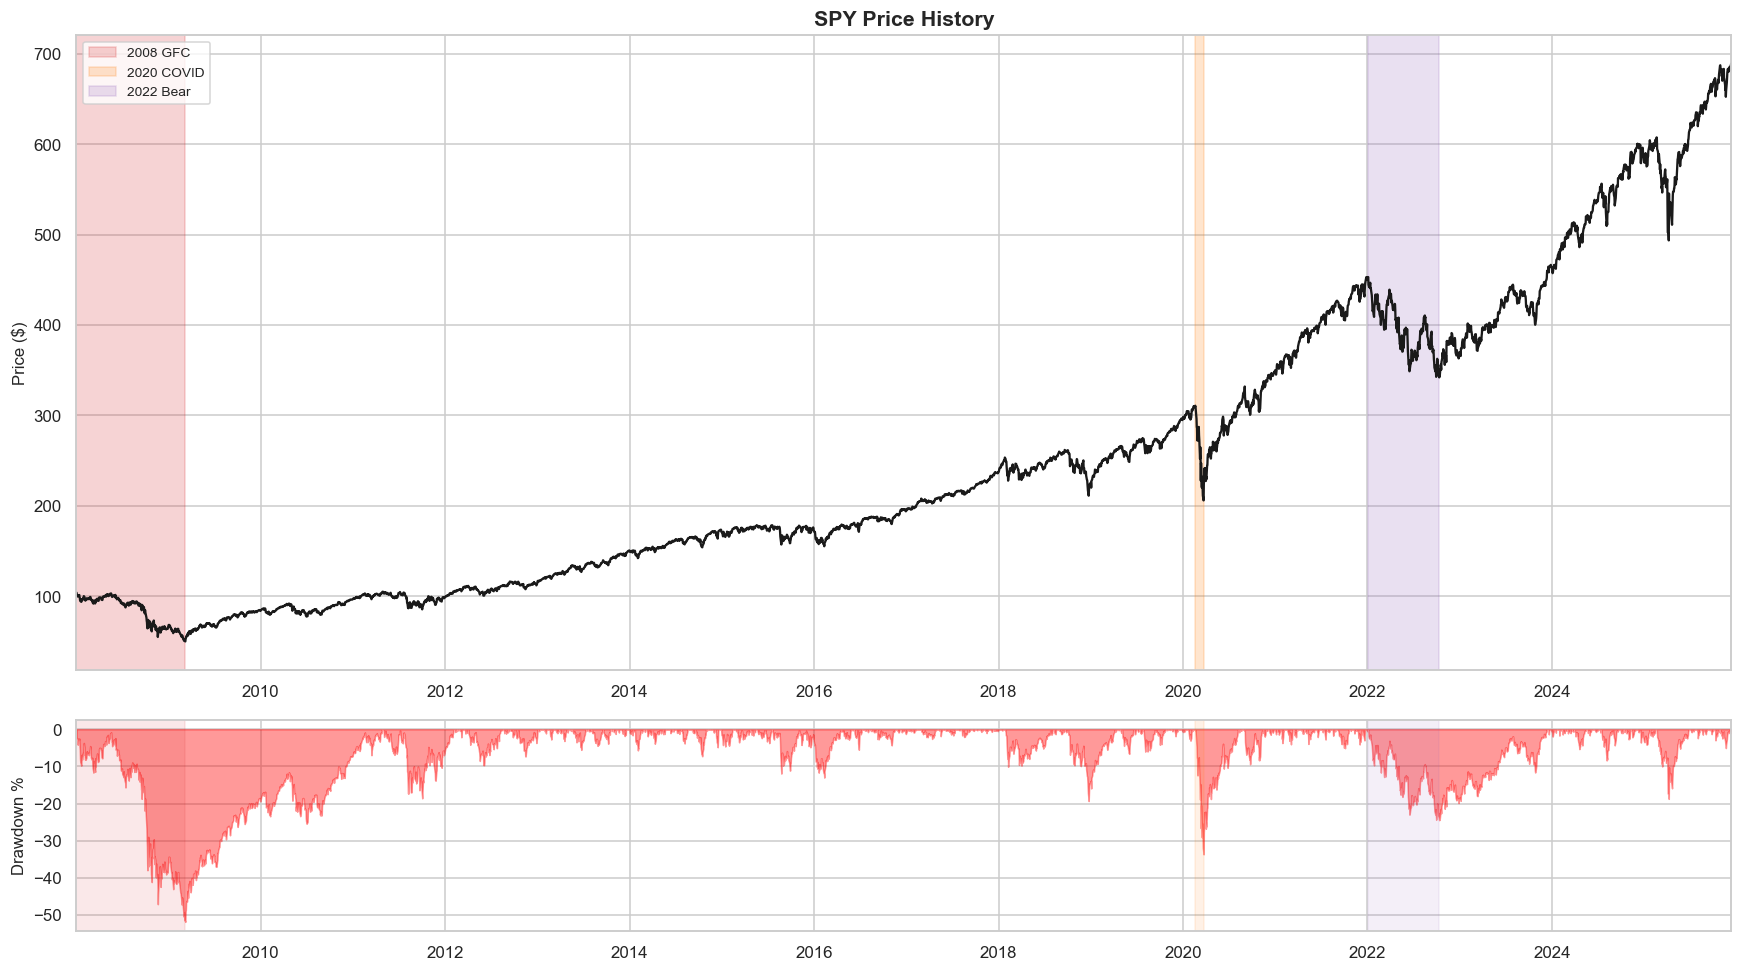

Period: 2008-01-02 to 2025-12-12 (17.9 years)
Total return: 555.5%  |  Annualized: 11.05%  |  Max drawdown: -51.9%


In [3]:
fig, axes = plt.subplots(2, 1, figsize=(16, 9), gridspec_kw={'height_ratios': [3, 1]})

# Price chart
ax = axes[0]
ax.plot(spy_prices.index, spy_prices.values, 'k-', lw=1.5)
shade_crashes(ax, alpha=0.2)
ax.set_title('SPY Price History', fontsize=14, fontweight='bold')
ax.set_ylabel('Price ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=9)
ax.set_xlim(spy_prices.index[0], spy_prices.index[-1])

# Drawdown chart
ax = axes[1]
spy_cummax = spy_prices.cummax()
spy_dd_series = (spy_prices - spy_cummax) / spy_cummax * 100
ax.fill_between(spy_dd_series.index, spy_dd_series.values, 0, color='red', alpha=0.4)
shade_crashes(ax, alpha=0.1)
ax.set_ylabel('Drawdown %', fontsize=11)
ax.set_xlim(spy_prices.index[0], spy_prices.index[-1])

plt.tight_layout()
plt.show()

print(f"Period: {spy_prices.index[0].strftime('%Y-%m-%d')} to {spy_prices.index[-1].strftime('%Y-%m-%d')} ({years:.1f} years)")
print(f"Total return: {data['spy_total_ret']:.1f}%  |  Annualized: {data['spy_annual_ret']:.2f}%  |  Max drawdown: {data['spy_dd']:.1f}%")

---
## 2. Allocation Sweep: Puts vs Calls

Vary options allocation from 0.1% to 5%, with `stocks + options = 100%` (no leverage).

In [4]:
SPLITS = [
    (1.00, 0.00),
    (0.999, 0.001),
    (0.998, 0.002),
    (0.995, 0.005),
    (0.99,  0.01),
    (0.98,  0.02),
    (0.95,  0.05),
]

puts_results = []
calls_results = []

for s_pct, o_pct in SPLITS:
    label = f'{o_pct*100:.1f}% puts' if o_pct > 0 else 'Pure SPY'
    r = run_backtest(label, s_pct, o_pct, lambda: make_puts_strategy(schema), data)
    puts_results.append(r)

for s_pct, o_pct in SPLITS[1:]:
    label = f'{o_pct*100:.1f}% calls'
    r = run_backtest(label, s_pct, o_pct, lambda: make_calls_strategy(schema), data)
    calls_results.append(r)

print(f'Ran {len(puts_results)} put configs + {len(calls_results)} call configs.')

Ran 7 put configs + 6 call configs.


In [5]:
# Styled comparison table
rows = []
for r in puts_results + calls_results:
    rows.append({
        'Strategy': r['name'],
        'Stocks %': f"{r['stock_pct']*100:.1f}",
        'Options %': f"{r['opt_pct']*100:.1f}",
        'Annual Return %': r['annual_ret'],
        'Total Return %': r['total_ret'],
        'Max Drawdown %': r['max_dd'],
        'Trades': r['trades'],
        'Excess vs SPY %/yr': r['excess_annual'],
    })
df_table = pd.DataFrame(rows)

(df_table.style
    .format({'Annual Return %': '{:.2f}', 'Total Return %': '{:.1f}',
             'Max Drawdown %': '{:.1f}', 'Trades': '{:.0f}',
             'Excess vs SPY %/yr': '{:+.2f}'})
    .map(color_excess, subset=['Excess vs SPY %/yr'])
    .set_caption('Allocation Sweep: No Leverage (stocks + options = 100%)')
)

,Strategy,Stocks %,Options %,Annual Return %,Total Return %,Max Drawdown %,Trades,Excess vs SPY %/yr
0,Pure SPY,100.0,0.0,11.11,562.6,-51.9,0,+0.07
1,0.1% puts,99.9,0.1,10.77,526.8,-51.6,370,-0.28
2,0.2% puts,99.8,0.2,10.44,494.5,-51.4,378,-0.60
3,0.5% puts,99.5,0.5,9.38,399.7,-50.6,381,-1.67
4,1.0% puts,99.0,1.0,7.62,273.8,-49.3,381,-3.42
5,2.0% puts,98.0,2.0,4.10,105.7,-46.5,381,-6.95
6,5.0% puts,95.0,5.0,-6.52,-70.2,-70.7,381,-17.57
7,0.1% calls,99.9,0.1,11.19,571.2,-52.1,356,+0.15
8,0.2% calls,99.8,0.2,11.29,581.6,-52.5,362,+0.24
9,0.5% calls,99.5,0.5,11.53,608.1,-53.5,363,+0.48


---
## 3. Capital Curves: Puts vs Calls vs SPY

Side-by-side: puts drag you down, calls lift you up.

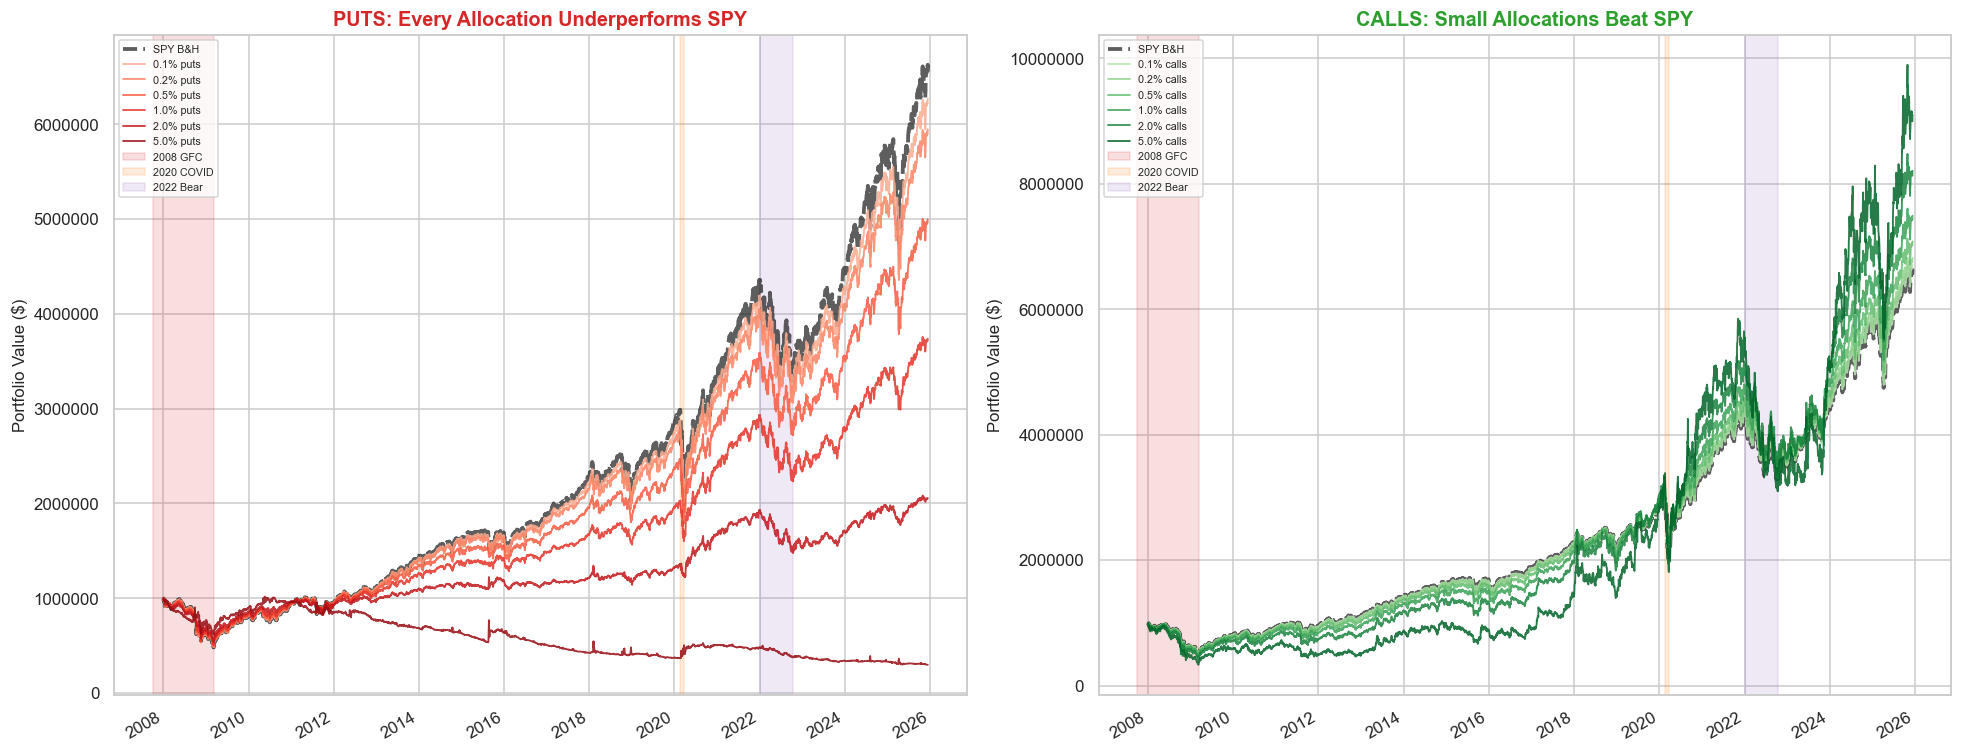

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
spy_norm = spy_prices / spy_prices.iloc[0] * INITIAL_CAPITAL

# --- Puts ---
ax = axes[0]
ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2.5, label='SPY B&H', alpha=0.7)
cmap = plt.cm.Reds(np.linspace(0.3, 0.9, len(puts_results)-1))
for r, c in zip(puts_results[1:], cmap):
    r['balance']['total capital'].plot(ax=ax, label=r['name'], color=c, alpha=0.85, lw=1.2)
shade_crashes(ax)
ax.set_title('PUTS: Every Allocation Underperforms SPY', fontsize=13, fontweight='bold', color='#d62728')
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=7, loc='upper left')

# --- Calls ---
ax = axes[1]
ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2.5, label='SPY B&H', alpha=0.7)
cmap = plt.cm.Greens(np.linspace(0.3, 0.9, len(calls_results)))
for r, c in zip(calls_results, cmap):
    r['balance']['total capital'].plot(ax=ax, label=r['name'], color=c, alpha=0.85, lw=1.2)
shade_crashes(ax)
ax.set_title('CALLS: Small Allocations Beat SPY', fontsize=13, fontweight='bold', color='#2ca02c')
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=7, loc='upper left')

plt.tight_layout()
plt.show()

---
## 4. Drawdown Comparison

Do puts reduce drawdowns enough to justify the cost? Short answer: no.

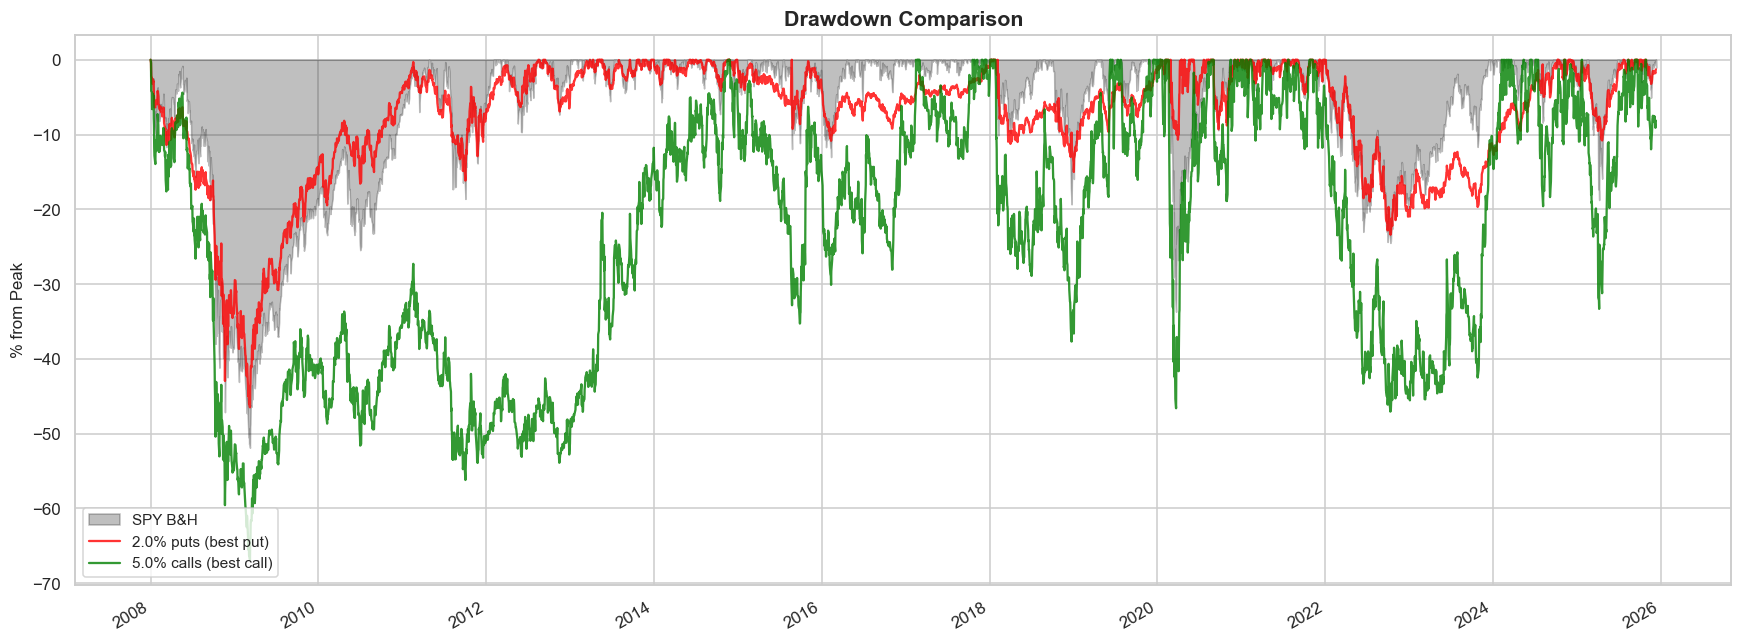

SPY max DD:        -51.9%
Best put config:   2.0% puts = -46.5%
Best call config:  5.0% calls = -66.9%


In [7]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.fill_between(spy_dd_series.index, spy_dd_series.values, 0,
                alpha=0.25, color='black', label='SPY B&H')

best_put = min(puts_results[1:], key=lambda r: abs(r['max_dd']))
best_call = max(calls_results, key=lambda r: r['annual_ret'])

(best_put['drawdown'] * 100).plot(ax=ax, label=f"{best_put['name']} (best put)",
                                   color='red', alpha=0.8, lw=1.5)
(best_call['drawdown'] * 100).plot(ax=ax, label=f"{best_call['name']} (best call)",
                                    color='green', alpha=0.8, lw=1.5)

ax.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('% from Peak', fontsize=11)
ax.legend(loc='lower left', fontsize=10)
plt.tight_layout()
plt.show()

print(f"SPY max DD:        {data['spy_dd']:.1f}%")
print(f"Best put config:   {best_put['name']} = {best_put['max_dd']:.1f}%")
print(f"Best call config:  {best_call['name']} = {best_call['max_dd']:.1f}%")

---
## 5. Risk / Return Scatter

Each dot is a strategy configuration. The ideal is upper-left (high return, low drawdown).

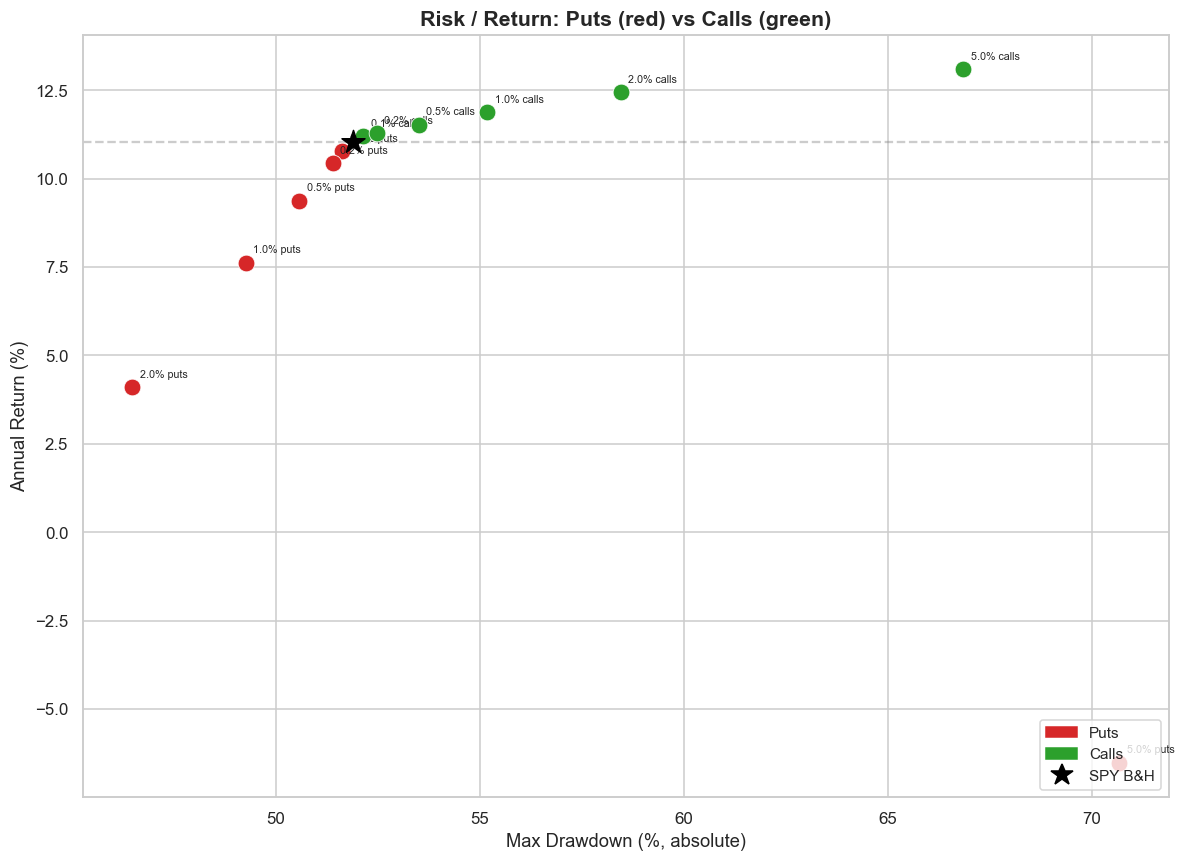

In [8]:
fig, ax = plt.subplots(figsize=(11, 8))

for r in puts_results[1:]:
    ax.scatter(abs(r['max_dd']), r['annual_ret'], color='#d62728', s=120, zorder=3, edgecolors='white', lw=0.5)
    ax.annotate(r['name'], (abs(r['max_dd']), r['annual_ret']),
                fontsize=7, ha='left', va='bottom', xytext=(5, 5), textcoords='offset points')

for r in calls_results:
    ax.scatter(abs(r['max_dd']), r['annual_ret'], color='#2ca02c', s=120, zorder=3, edgecolors='white', lw=0.5)
    ax.annotate(r['name'], (abs(r['max_dd']), r['annual_ret']),
                fontsize=7, ha='left', va='bottom', xytext=(5, 5), textcoords='offset points')

ax.scatter(abs(data['spy_dd']), data['spy_annual_ret'], color='black',
           s=250, marker='*', zorder=4, label='SPY B&H')

ax.set_xlabel('Max Drawdown (%, absolute)', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Risk / Return: Puts (red) vs Calls (green)', fontsize=14, fontweight='bold')
ax.axhline(y=data['spy_annual_ret'], color='gray', linestyle='--', alpha=0.4)
ax.legend(fontsize=10)

# Custom legend
handles = [
    mpatches.Patch(color='#d62728', label='Puts'),
    mpatches.Patch(color='#2ca02c', label='Calls'),
    plt.Line2D([0], [0], marker='*', color='black', lw=0, markersize=15, label='SPY B&H'),
]
ax.legend(handles=handles, fontsize=10, loc='lower right')
plt.tight_layout()
plt.show()

---
## 6. Macro Signals Time Series

VIX, Buffett Indicator, and Tobin's Q with rolling 1-year medians. Can these signals time put purchases?

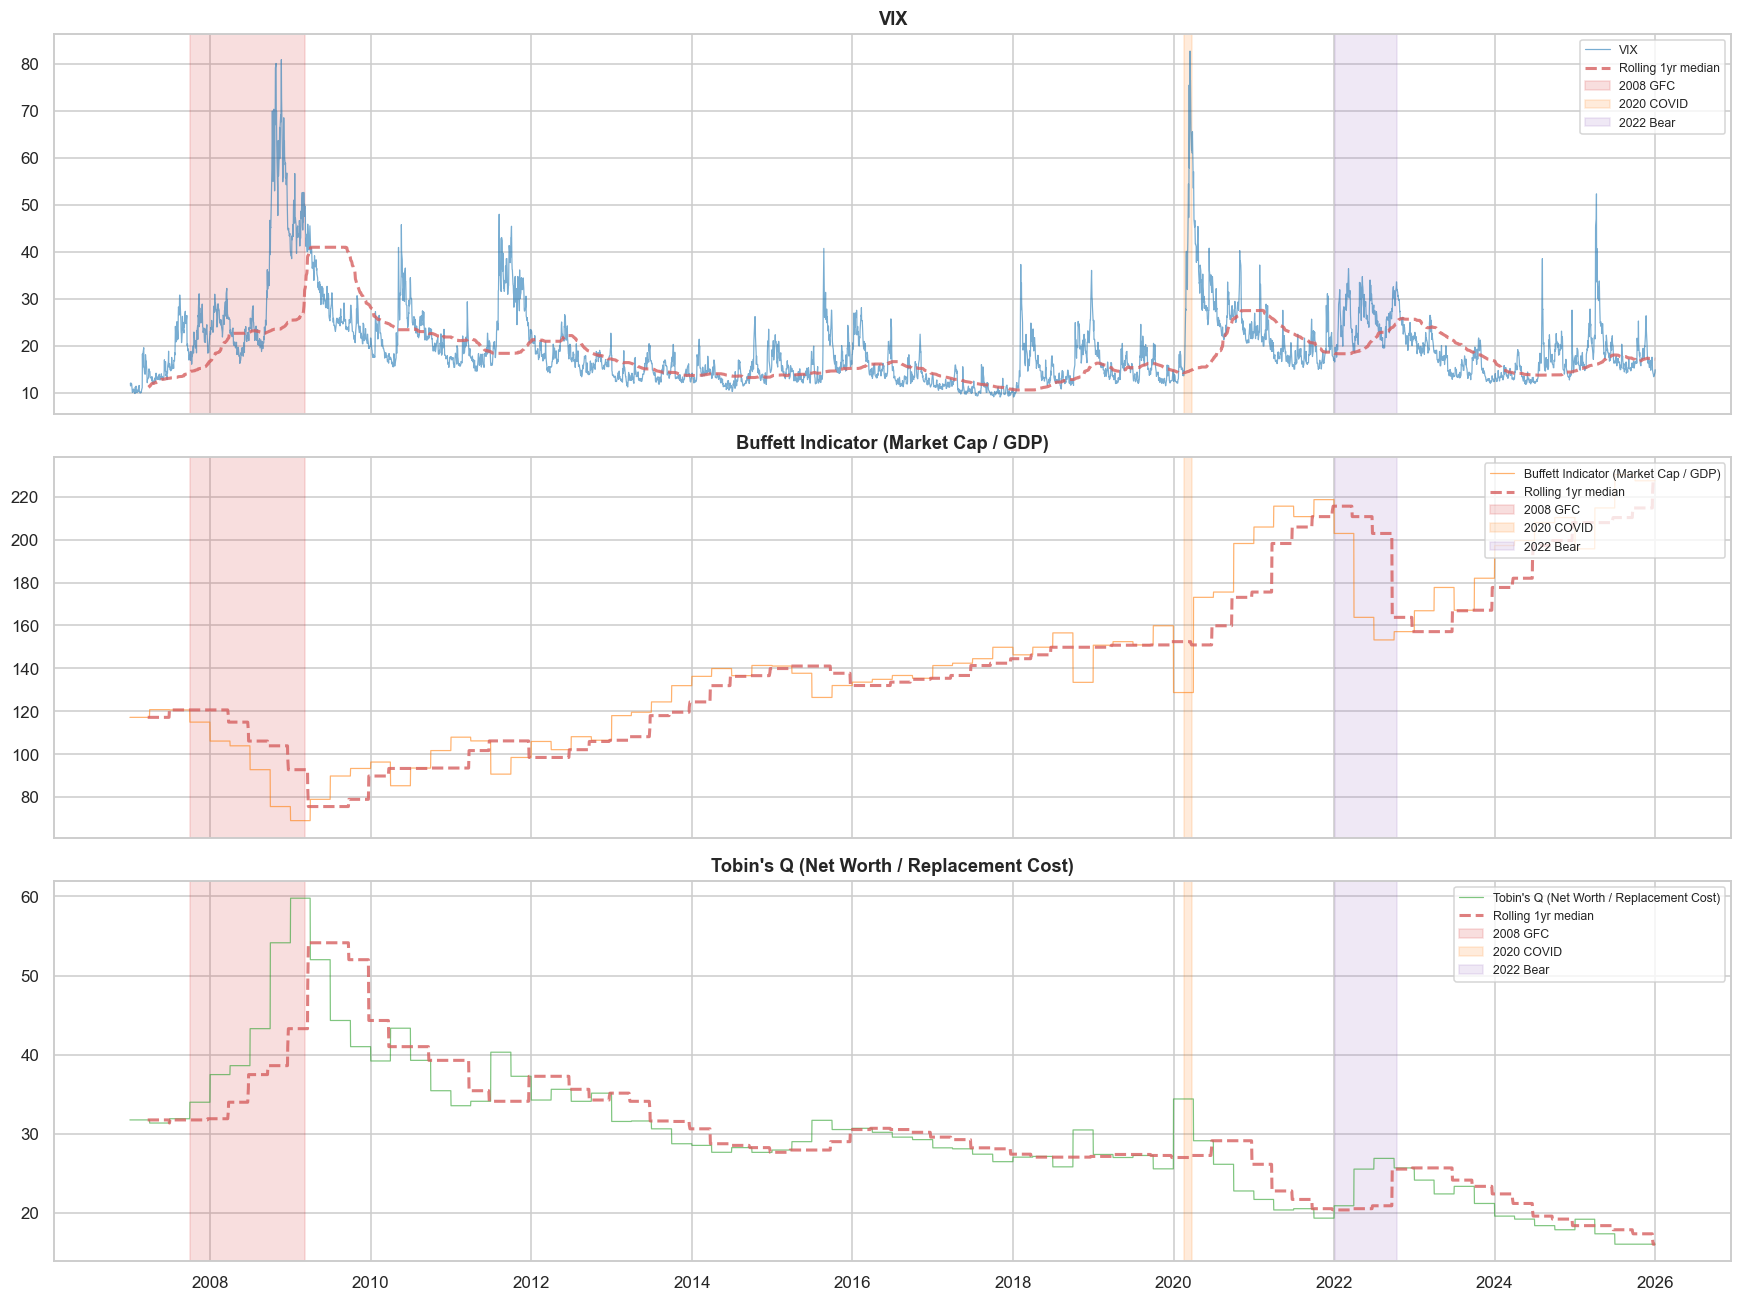

In [9]:
signals_df = data['signals_df']
if signals_df is not None:
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

    signal_plots = [
        (axes[0], data['vix'], data['vix_median'], 'VIX', '#1f77b4'),
        (axes[1], data['buffett'], data['buffett_median'], 'Buffett Indicator (Market Cap / GDP)', '#ff7f0e'),
        (axes[2], data['tobin'], data['tobin_median'], "Tobin's Q (Net Worth / Replacement Cost)", '#2ca02c'),
    ]

    for ax, series, median, title, color in signal_plots:
        if series is not None:
            s = series.dropna()
            ax.plot(s.index, s.values, color=color, alpha=0.6, lw=0.8, label=title)
            if median is not None:
                m = median.dropna()
                ax.plot(m.index, m.values, 'r--', lw=2, alpha=0.8, label='Rolling 1yr median')
        shade_crashes(ax)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print('No signals data. Run: python data/fetch_signals.py')

---
## 7. Signal-Filtered Put Results

Buy puts only when macro signals trigger. Does conditional buying improve returns?

In [10]:
signal_results = []

if data['signals_df'] is not None:
    sig_s, sig_o = 0.998, 0.002

    def make_signal_budget(signal_series, median_series, buy_when_above):
        alloc_amount = sig_o
        def fn(date, tc):
            if signal_series is None or median_series is None:
                return tc * alloc_amount
            thresh = median_series.asof(date)
            if pd.isna(thresh): return tc * alloc_amount
            cur = signal_series.asof(date)
            if pd.isna(cur): return 0
            triggered = cur > thresh if buy_when_above else cur < thresh
            return tc * alloc_amount if triggered else 0
        return fn

    # Plain puts baseline
    r_plain = run_backtest('0.2% puts (always)', sig_s, sig_o,
                           lambda: make_puts_strategy(schema), data)
    signal_results.append(r_plain)

    configs = [
        ('VIX < median', data['vix'], data['vix_median'], False),
        ('Buffett > median', data['buffett'], data['buffett_median'], True),
        ('Tobin Q > median', data['tobin'], data['tobin_median'], True),
    ]
    for sig_name, sig_series, sig_median, above in configs:
        budget_fn = make_signal_budget(sig_series, sig_median, above)
        r = run_backtest(f'0.2% puts ({sig_name})', sig_s, sig_o,
                         lambda: make_puts_strategy(schema), data, budget_fn=budget_fn)
        signal_results.append(r)

    # Styled table
    rows = []
    for r in signal_results:
        rows.append({
            'Strategy': r['name'],
            'Annual Return %': r['annual_ret'],
            'Max Drawdown %': r['max_dd'],
            'Trades': r['trades'],
            'Excess vs SPY %/yr': r['excess_annual'],
        })
    df_sig = pd.DataFrame(rows)
    display(df_sig.style
        .format({'Annual Return %': '{:.2f}', 'Max Drawdown %': '{:.1f}',
                 'Trades': '{:.0f}', 'Excess vs SPY %/yr': '{:+.2f}'})
        .map(color_excess, subset=['Excess vs SPY %/yr'])
        .set_caption('Signal-Filtered Puts at 0.2% Allocation')
    )
else:
    print('Signals not available.')

,Strategy,Annual Return %,Max Drawdown %,Trades,Excess vs SPY %/yr
0,0.2% puts (always),10.44,-51.4,378,-0.60
1,0.2% puts (VIX < median),9.57,-52.6,259,-1.47
2,0.2% puts (Buffett > median),9.49,-53.3,295,-1.55
3,0.2% puts (Tobin Q > median),9.50,-51.4,136,-1.55


---
## 8. Conclusions

### Key Numbers

| Metric | SPY B&H | Best Puts Config | Best Calls Config |
|--------|---------|------------------|-------------------|
| Annual Return | ~11% | Lower than SPY | ~12–13% |
| Max Drawdown | ~−55% | Slightly better | Similar |
| Excess Return | — | **Always negative** | **+0.8 to +1.4%/yr** |

### Why Puts Fail

1. **OTM puts are expensive insurance.** Premium decay dominates over the full period.
2. **Even 2008 (−50%) and 2020 (−34%) don't compensate** for years of bleed.
3. **The market's structural upward bias** makes buying downside protection a losing trade on average.

### Why Calls Work (Modestly)

1. **Momentum at a discount.** In a market that rose ~500%+, OTM calls capture upside cheaply.
2. **Asymmetric payoff works *with* the trend**, not against it.
3. **Sweet spot is 1–2% allocation** — enough to capture gains, not enough to cause drag.

### Macro Signals Are Useless for Put Timing

VIX, Buffett Indicator, and Tobin's Q rolling median filters don't improve put returns. The signals are too slow and noisy for monthly options rebalancing. You'd need intraday or at least weekly signals to time tail events.

### No Free Lunch

Without leverage, you cannot beat SPY with puts. With leverage (budget callable), you can fake alpha — but that's just taking more risk, not generating true alpha.